# PIGPVAE cooling 

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *
from VAE_utils import AnnealingStrategy

from Models.PIGPVAE_lognorm import PIGPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD417'] + df['B.ASTRHT2.T'])/2
df_c = df.copy()
df_c = df[df['temp_change_class'] == 'c']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_c = df_c.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23520/3618831305.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var):
        self.df = df
        self.select_var = select_var
        self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch
# Initialize the dataset and train_loader
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_c,select_var)
# Split the dataset into above_20 and below_20
above_20_data = []
below_20_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 20:
        above_20_data.append(x_batch)
    else:
        below_20_data.append(x_batch)

# Define custom datasets for above_20 and below_20
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
below_20_dataset = SubsetDataset(below_20_data)
above_20_dataset = SubsetDataset(above_20_data)

train_loader = DataLoader(above_20_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_20_dataset, batch_size=1, shuffle=True)

# Check DataLoader sizes
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 21
Number of batches in val_loader: 7


In [4]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ReLU(),
                trainable_alpha=True,
                initial_alpha=0.1
               )

In [5]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha

# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [6]:
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None

In [7]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

Training Progress:   5%|▍         | 25/550 [00:02<00:50, 10.45it/s]

Epoch 27: Train Loss = 1.2917, KL_phy = 0.0768, KL_delta = -0.2879, MSE = 1.2893, CE = 1.2044, Reg_Loss = 0.0464, Alpha = 0.0975
Validation Loss = 3.0704, Val_KL_phy = 0.0644, Val_KL_delta = -0.3357, Val_MSE = 3.0710, Val_CE = 1.2311, Val_Reg_Loss = 0.0218, Val_Alpha = 0.0975


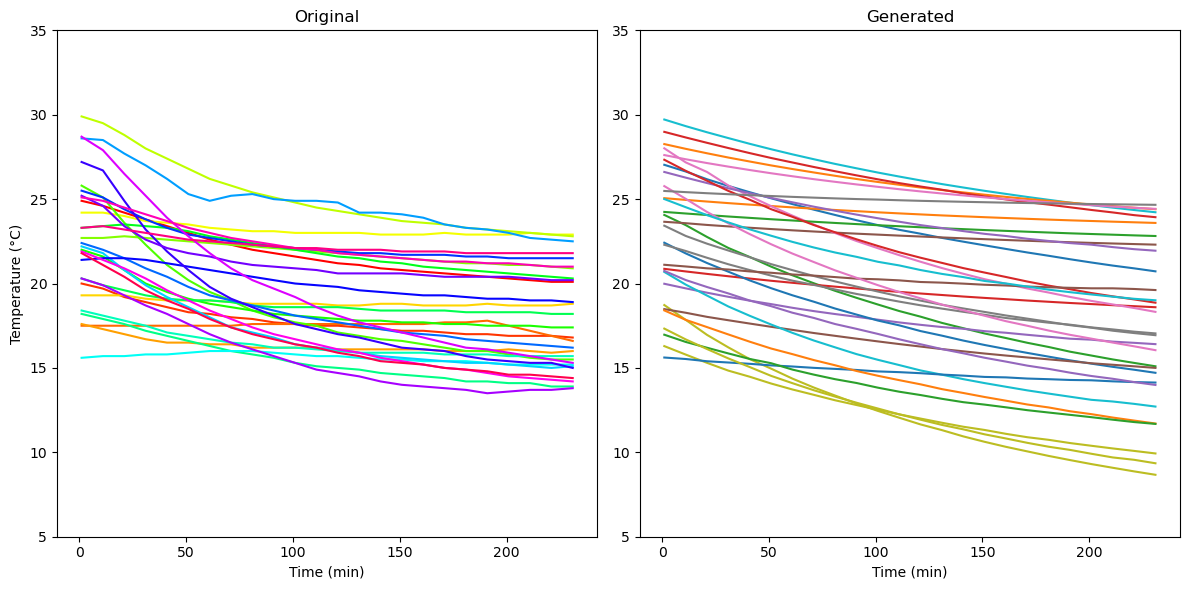

Training Progress:   9%|▉         | 52/550 [00:05<00:47, 10.41it/s]

Epoch 54: Train Loss = 0.8407, KL_phy = 0.2212, KL_delta = 0.0664, MSE = 0.8191, CE = 0.2289, Reg_Loss = 0.2030, Alpha = 0.0919
Validation Loss = 2.4475, Val_KL_phy = 0.2092, Val_KL_delta = -0.1020, Val_MSE = 2.4377, Val_CE = 0.3678, Val_Reg_Loss = 0.0949, Val_Alpha = 0.0918


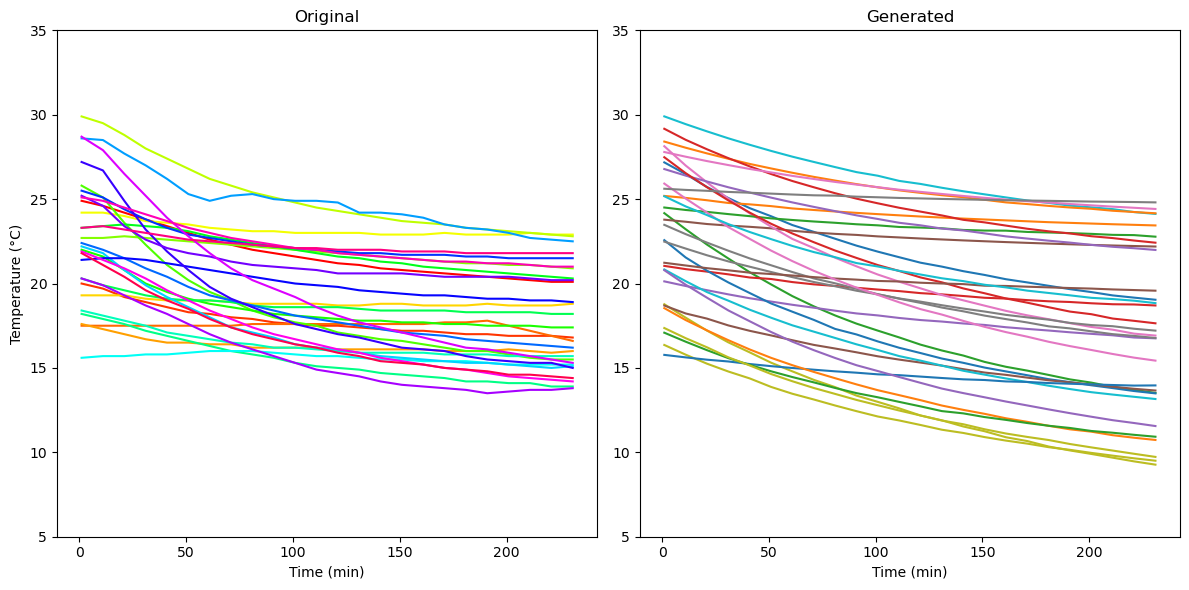

Training Progress:  15%|█▍        | 80/550 [00:08<00:45, 10.39it/s]

Epoch 81: Train Loss = 0.8873, KL_phy = 0.2968, KL_delta = 0.2788, MSE = 0.8585, CE = 0.1013, Reg_Loss = 0.2674, Alpha = 0.0864
Validation Loss = 2.4410, Val_KL_phy = 0.2867, Val_KL_delta = 0.0972, Val_MSE = 2.4161, Val_CE = 0.1171, Val_Reg_Loss = 0.2432, Val_Alpha = 0.0863


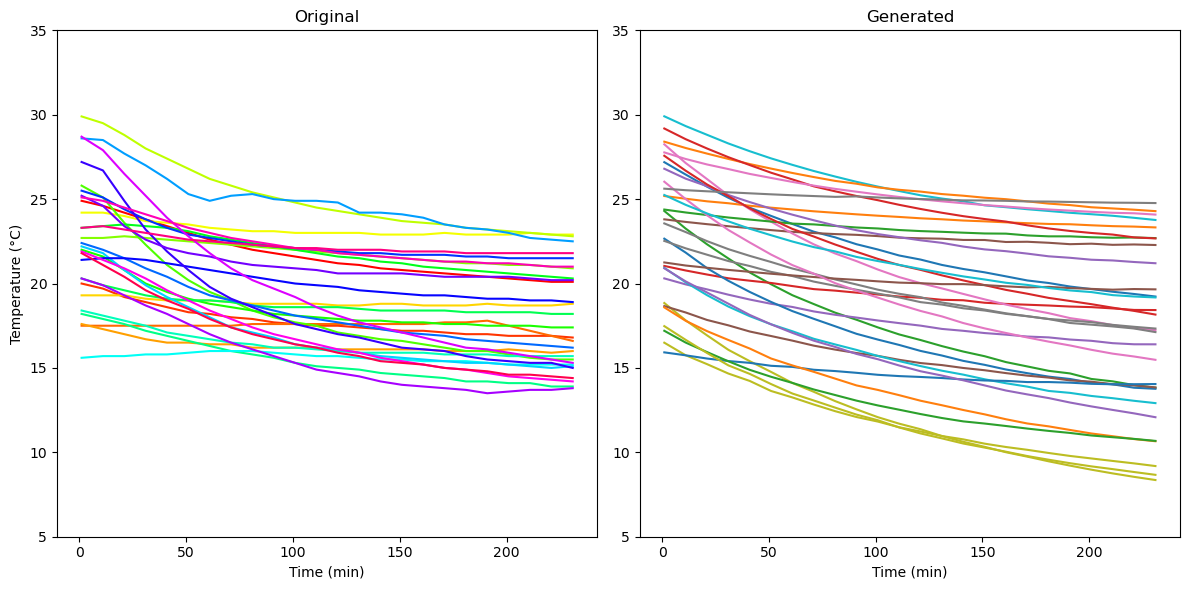

Training Progress:  19%|█▉        | 107/550 [00:10<00:42, 10.36it/s]

Epoch 108: Train Loss = 0.9857, KL_phy = 0.3994, KL_delta = 0.6204, MSE = 0.9282, CE = 0.1149, Reg_Loss = 0.5836, Alpha = 0.0811
Validation Loss = 2.5196, Val_KL_phy = 0.3895, Val_KL_delta = 0.2518, Val_MSE = 2.4910, Val_CE = 0.0985, Val_Reg_Loss = 0.2745, Val_Alpha = 0.0810


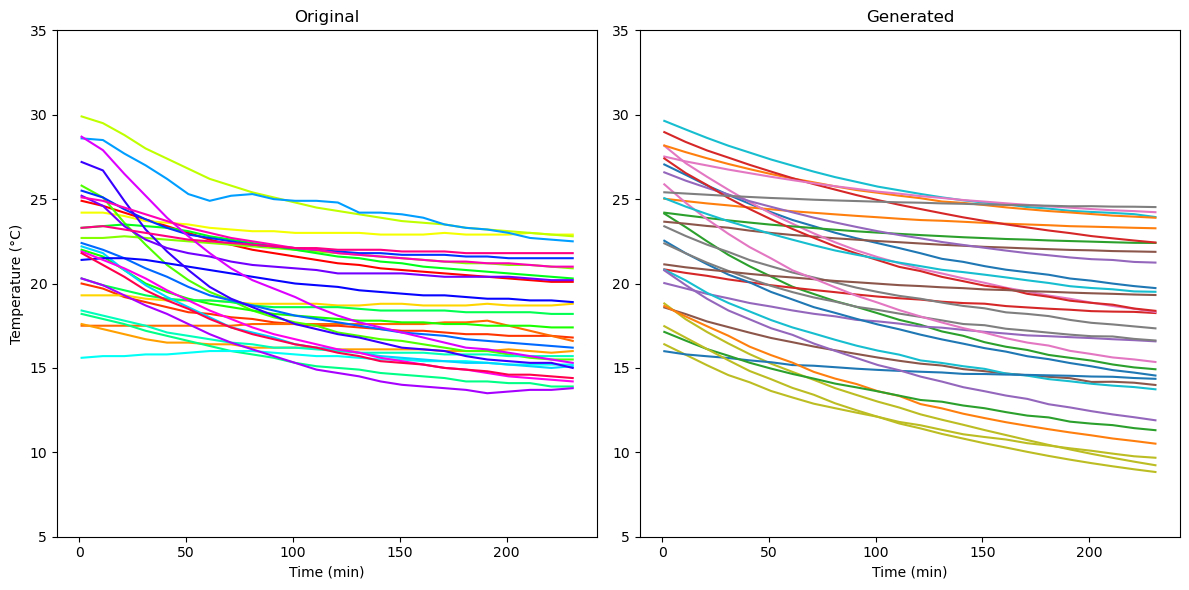

Training Progress:  24%|██▍       | 133/550 [00:13<00:40, 10.35it/s]

Epoch 135: Train Loss = 0.7387, KL_phy = 0.4782, KL_delta = 0.8648, MSE = 0.6882, CE = 0.1418, Reg_Loss = 0.4837, Alpha = 0.0766
Validation Loss = 2.2085, Val_KL_phy = 0.4672, Val_KL_delta = 0.5245, Val_MSE = 2.1464, Val_CE = 0.1262, Val_Reg_Loss = 0.6814, Val_Alpha = 0.0765


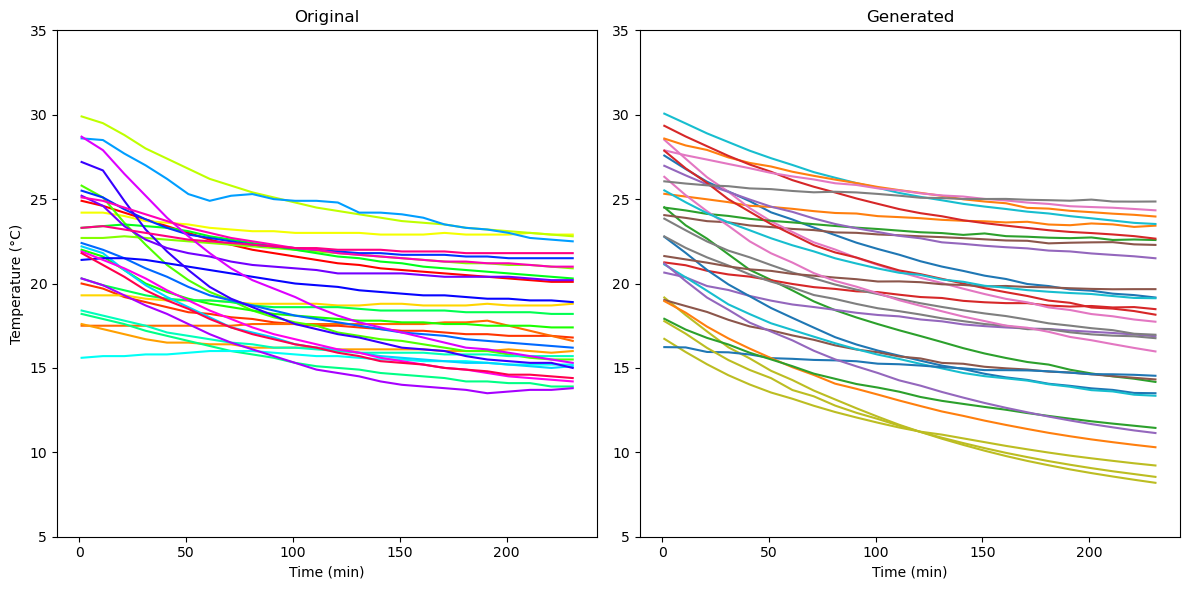

Training Progress:  29%|██▉       | 160/550 [00:16<00:38, 10.24it/s]

Epoch 162: Train Loss = 0.7336, KL_phy = 0.5567, KL_delta = 1.2233, MSE = 0.6808, CE = 0.1674, Reg_Loss = 0.4824, Alpha = 0.0725
Validation Loss = 1.5350, Val_KL_phy = 0.5426, Val_KL_delta = 0.7331, Val_MSE = 1.4804, Val_CE = 0.1462, Val_Reg_Loss = 0.5774, Val_Alpha = 0.0724


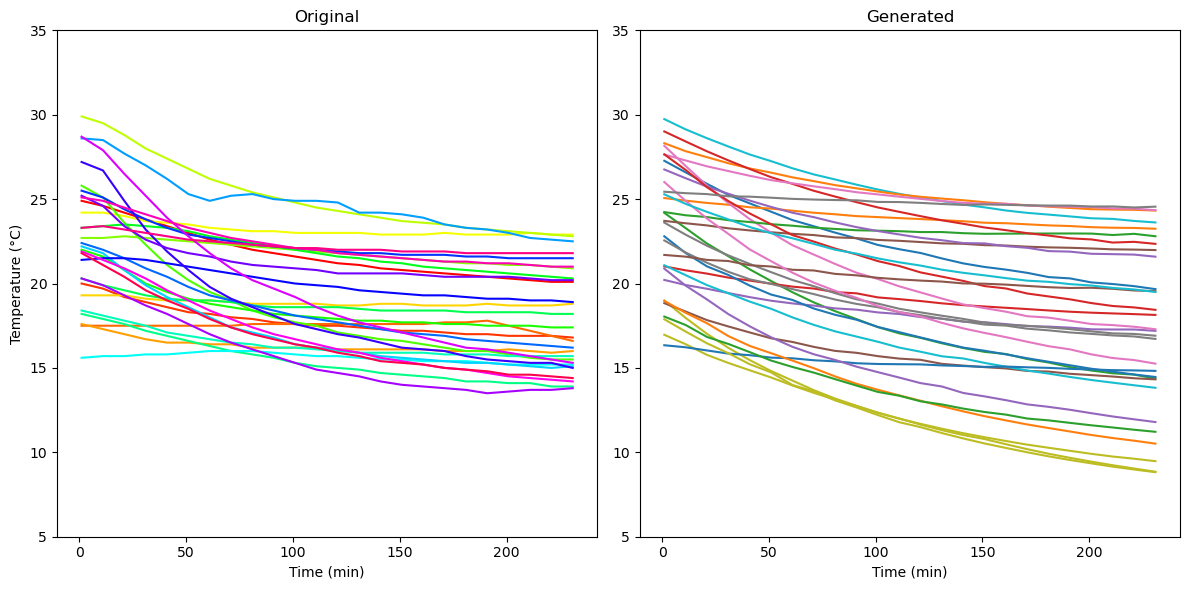

Training Progress:  34%|███▍      | 188/550 [00:19<00:34, 10.36it/s]

Epoch 189: Train Loss = 0.8074, KL_phy = 0.6244, KL_delta = 1.8307, MSE = 0.7297, CE = 0.1990, Reg_Loss = 0.7700, Alpha = 0.0691
Validation Loss = 2.2085, Val_KL_phy = 0.6059, Val_KL_delta = 0.9587, Val_MSE = 2.1642, Val_CE = 0.1341, Val_Reg_Loss = 0.4150, Val_Alpha = 0.0690


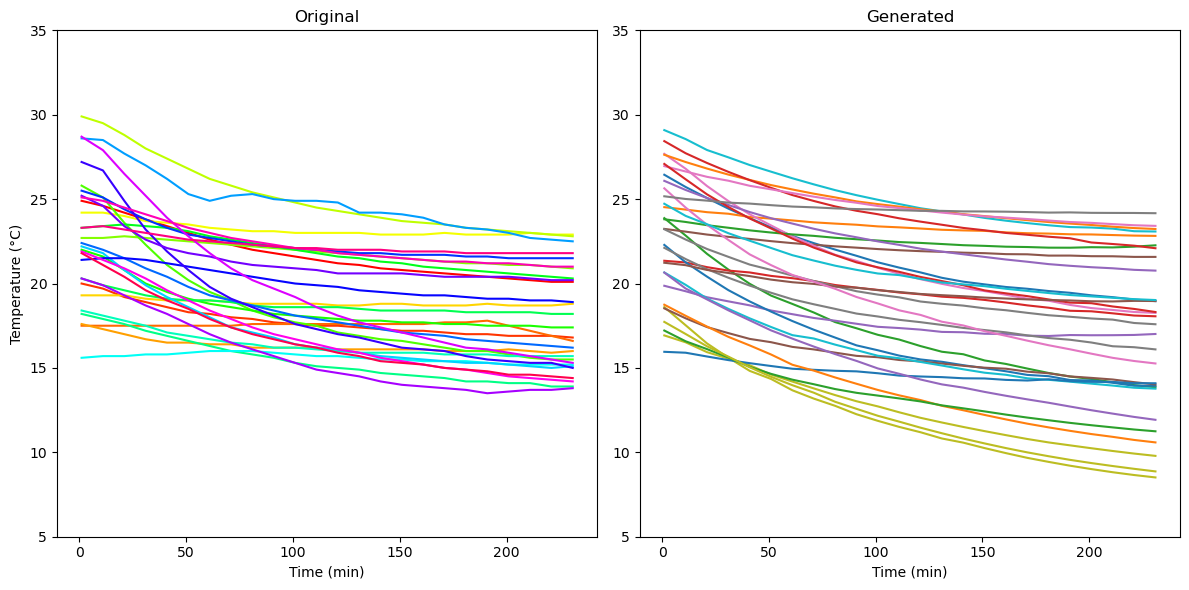

Training Progress:  39%|███▉      | 215/550 [00:21<00:32, 10.39it/s]

Epoch 216: Train Loss = 0.5562, KL_phy = 0.7188, KL_delta = 2.2651, MSE = 0.4956, CE = 0.2241, Reg_Loss = 0.4667, Alpha = 0.0659
Validation Loss = 1.3983, Val_KL_phy = 0.6932, Val_KL_delta = 1.4509, Val_MSE = 1.2985, Val_CE = 0.1810, Val_Reg_Loss = 1.1882, Val_Alpha = 0.0659


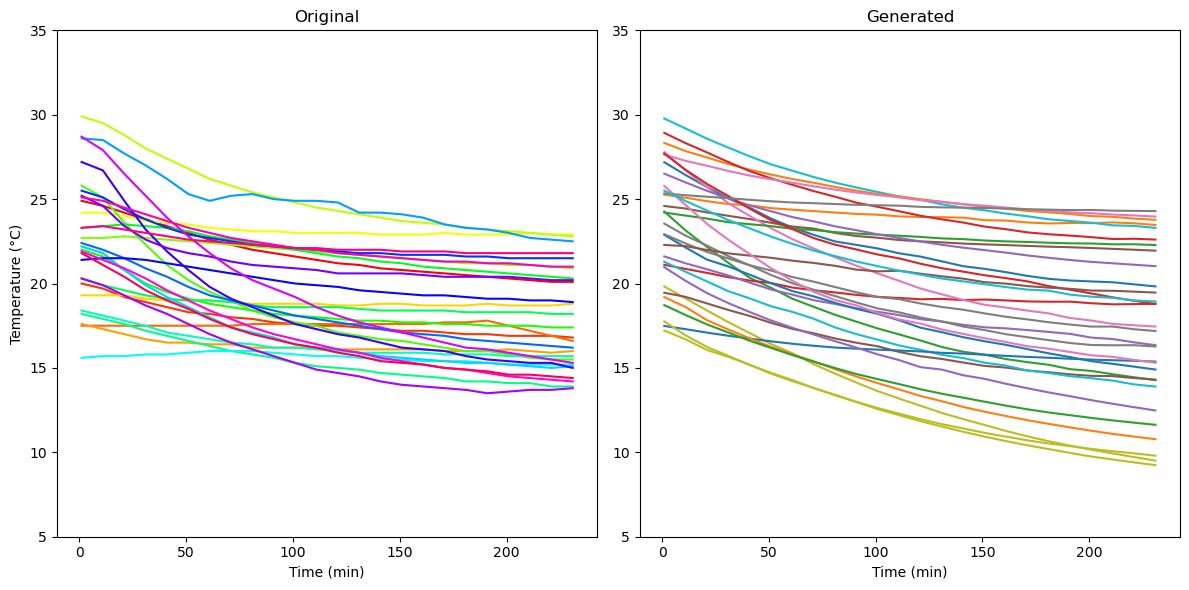

Training Progress:  44%|████▍     | 242/550 [00:24<00:29, 10.30it/s]

Epoch 243: Train Loss = 0.5603, KL_phy = 0.7284, KL_delta = 2.8916, MSE = 0.4924, CE = 0.2591, Reg_Loss = 0.5028, Alpha = 0.0631
Validation Loss = 1.2769, Val_KL_phy = 0.6993, Val_KL_delta = 1.7284, Val_MSE = 1.1900, Val_CE = 0.1666, Val_Reg_Loss = 0.9930, Val_Alpha = 0.0631


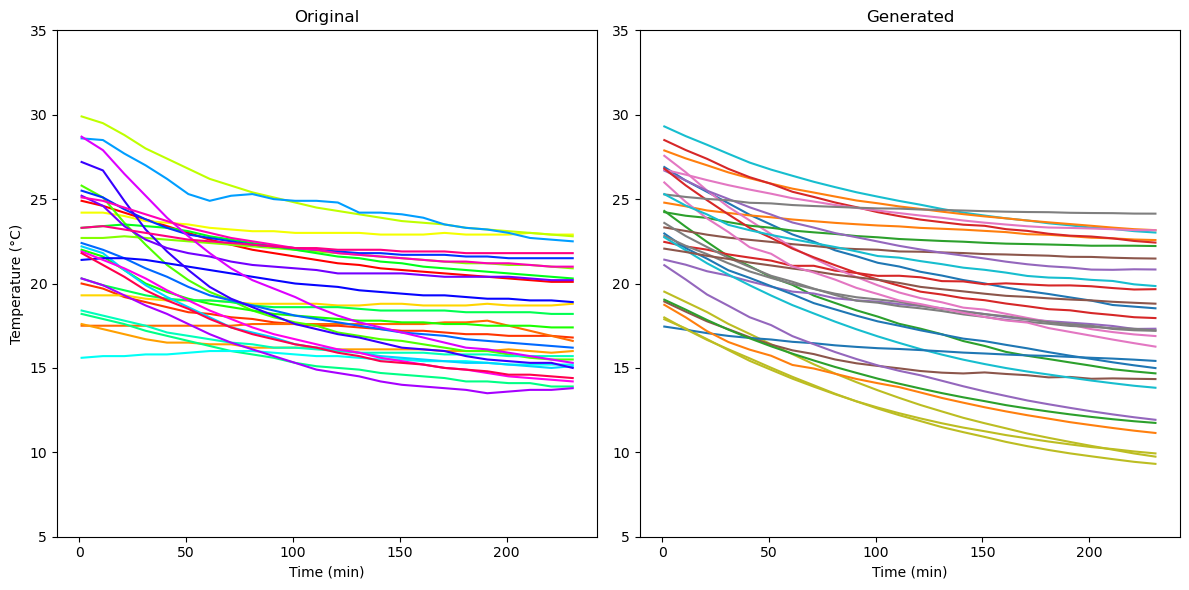

Training Progress:  49%|████▉     | 269/550 [00:27<00:27, 10.31it/s]

Epoch 270: Train Loss = 0.3915, KL_phy = 0.7924, KL_delta = 3.5933, MSE = 0.3136, CE = 0.2883, Reg_Loss = 0.5609, Alpha = 0.0607
Validation Loss = 0.9096, Val_KL_phy = 0.7624, Val_KL_delta = 2.1364, Val_MSE = 0.8075, Val_CE = 0.1587, Val_Reg_Loss = 1.2054, Val_Alpha = 0.0606


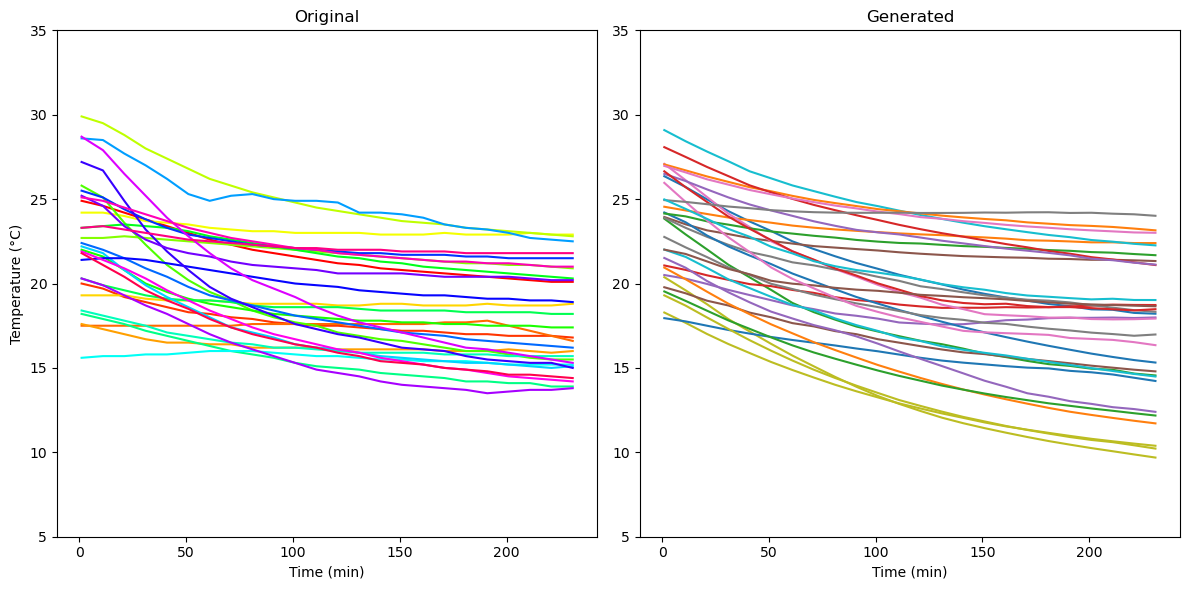

Training Progress:  54%|█████▍    | 296/550 [00:30<00:24, 10.29it/s]

Epoch 297: Train Loss = 0.3473, KL_phy = 0.8272, KL_delta = 4.0999, MSE = 0.2683, CE = 0.2900, Reg_Loss = 0.5106, Alpha = 0.0583
Validation Loss = 0.7921, Val_KL_phy = 0.7924, Val_KL_delta = 2.5224, Val_MSE = 0.6428, Val_CE = 0.1862, Val_Reg_Loss = 1.9939, Val_Alpha = 0.0582


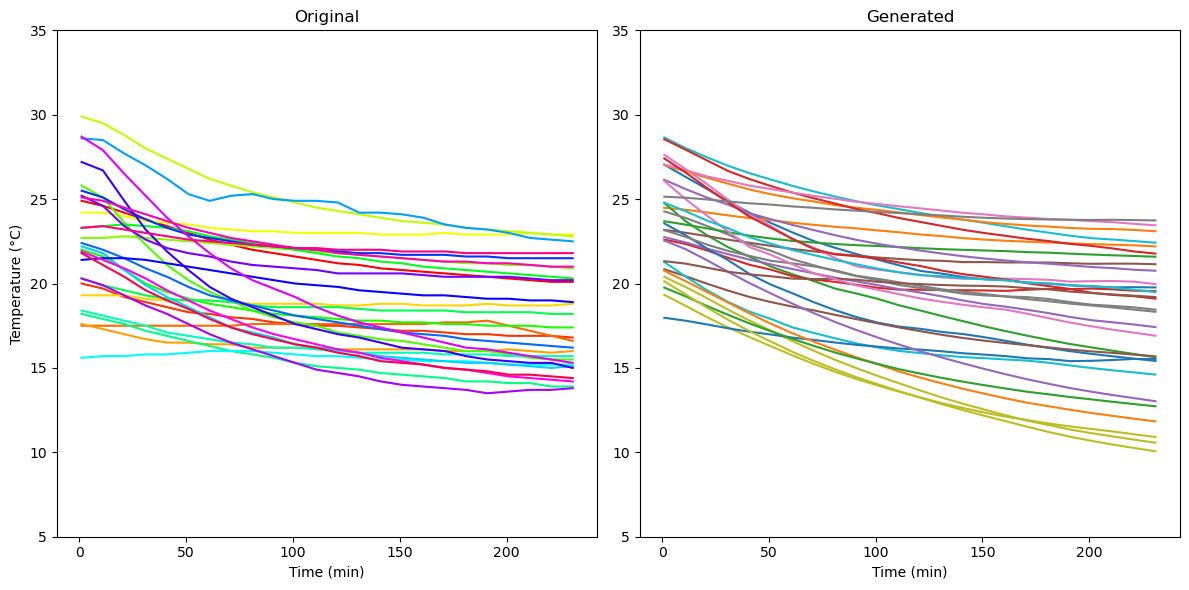

Training Progress:  59%|█████▊    | 323/550 [00:32<00:21, 10.33it/s]

Epoch 324: Train Loss = 0.2862, KL_phy = 0.8626, KL_delta = 4.5509, MSE = 0.1991, CE = 0.3112, Reg_Loss = 0.5899, Alpha = 0.0557
Validation Loss = 0.5793, Val_KL_phy = 0.8260, Val_KL_delta = 2.7053, Val_MSE = 0.4574, Val_CE = 0.1545, Val_Reg_Loss = 1.5540, Val_Alpha = 0.0557


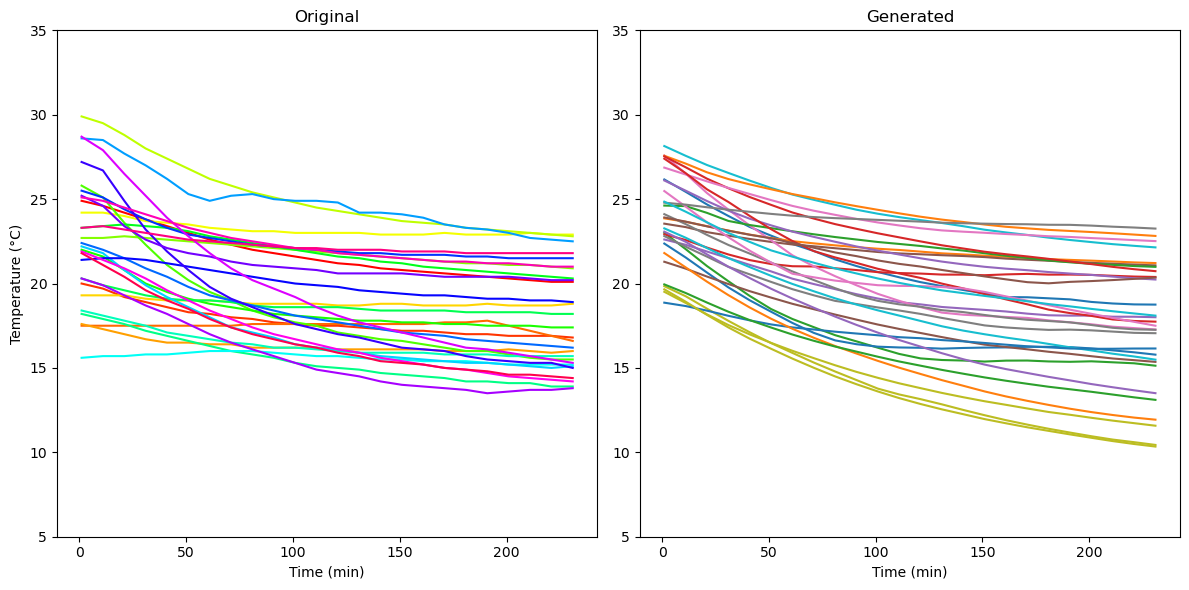

Training Progress:  64%|██████▎   | 350/550 [00:35<00:19, 10.26it/s]

Epoch 351: Train Loss = 0.2467, KL_phy = 0.8580, KL_delta = 4.7932, MSE = 0.1561, CE = 0.3202, Reg_Loss = 0.6379, Alpha = 0.0533
Validation Loss = 0.5279, Val_KL_phy = 0.8202, Val_KL_delta = 2.7919, Val_MSE = 0.4128, Val_CE = 0.1491, Val_Reg_Loss = 1.4838, Val_Alpha = 0.0533


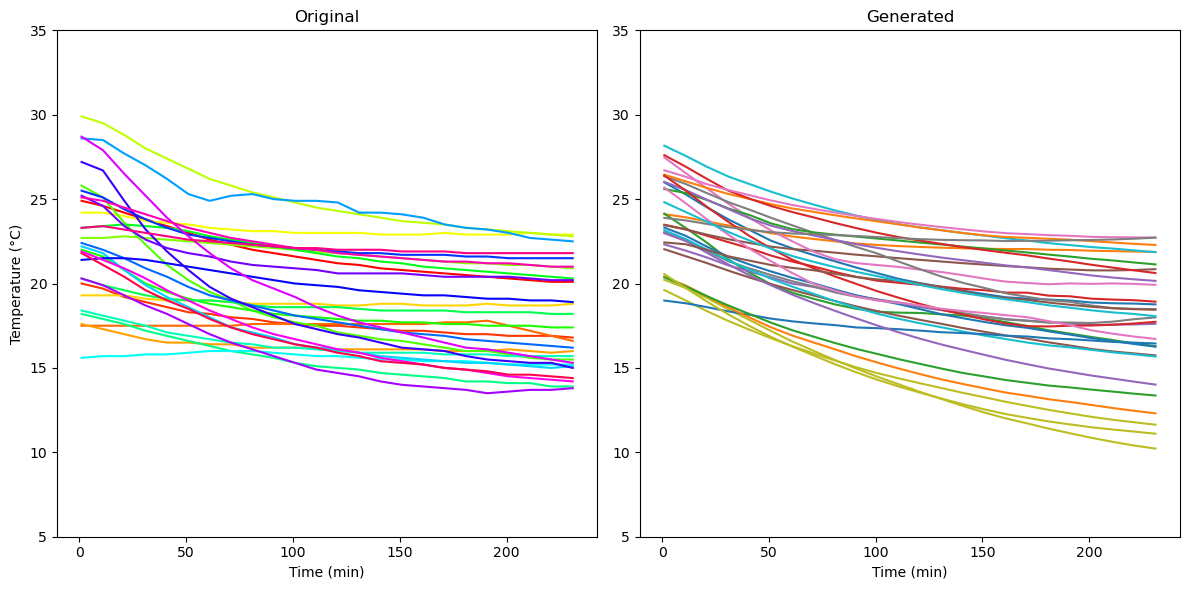

Training Progress:  69%|██████▊   | 377/550 [00:38<00:16, 10.25it/s]

Epoch 378: Train Loss = 0.3017, KL_phy = 0.8615, KL_delta = 4.9336, MSE = 0.2076, CE = 0.3279, Reg_Loss = 0.7077, Alpha = 0.0510
Validation Loss = 0.6445, Val_KL_phy = 0.8178, Val_KL_delta = 2.8847, Val_MSE = 0.5257, Val_CE = 0.1661, Val_Reg_Loss = 1.6046, Val_Alpha = 0.0510


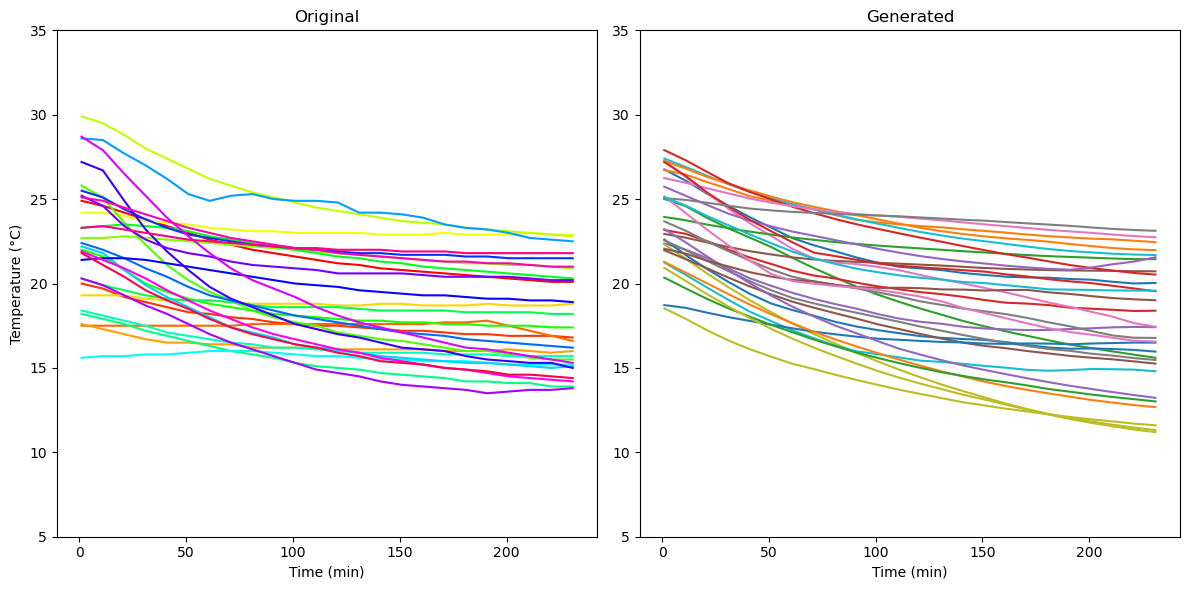

Training Progress:  73%|███████▎  | 404/550 [00:41<00:14, 10.13it/s]

Epoch 405: Train Loss = 0.2362, KL_phy = 0.8320, KL_delta = 5.0066, MSE = 0.1443, CE = 0.3289, Reg_Loss = 0.6854, Alpha = 0.0490
Validation Loss = 0.5940, Val_KL_phy = 0.7946, Val_KL_delta = 2.9525, Val_MSE = 0.4541, Val_CE = 0.1543, Val_Reg_Loss = 2.0934, Val_Alpha = 0.0489


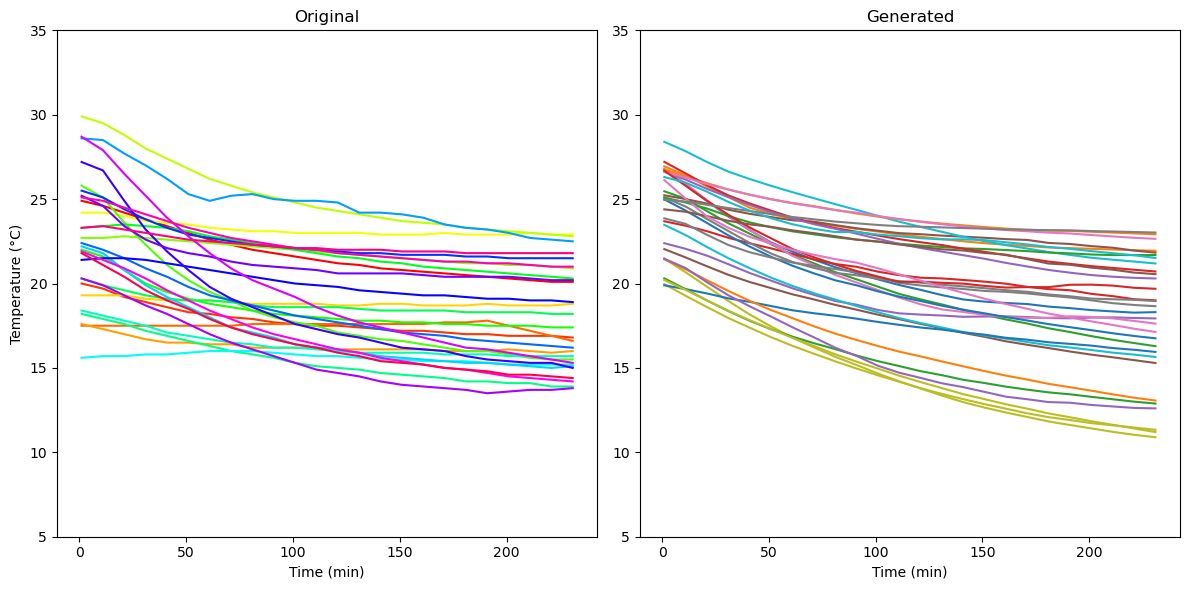

Training Progress:  78%|███████▊  | 431/550 [00:44<00:11, 10.17it/s]

Epoch 432: Train Loss = 0.2279, KL_phy = 0.8400, KL_delta = 4.9187, MSE = 0.1424, CE = 0.3217, Reg_Loss = 0.5959, Alpha = 0.0470
Validation Loss = 0.5545, Val_KL_phy = 0.7929, Val_KL_delta = 2.8437, Val_MSE = 0.4389, Val_CE = 0.1464, Val_Reg_Loss = 1.6884, Val_Alpha = 0.0469


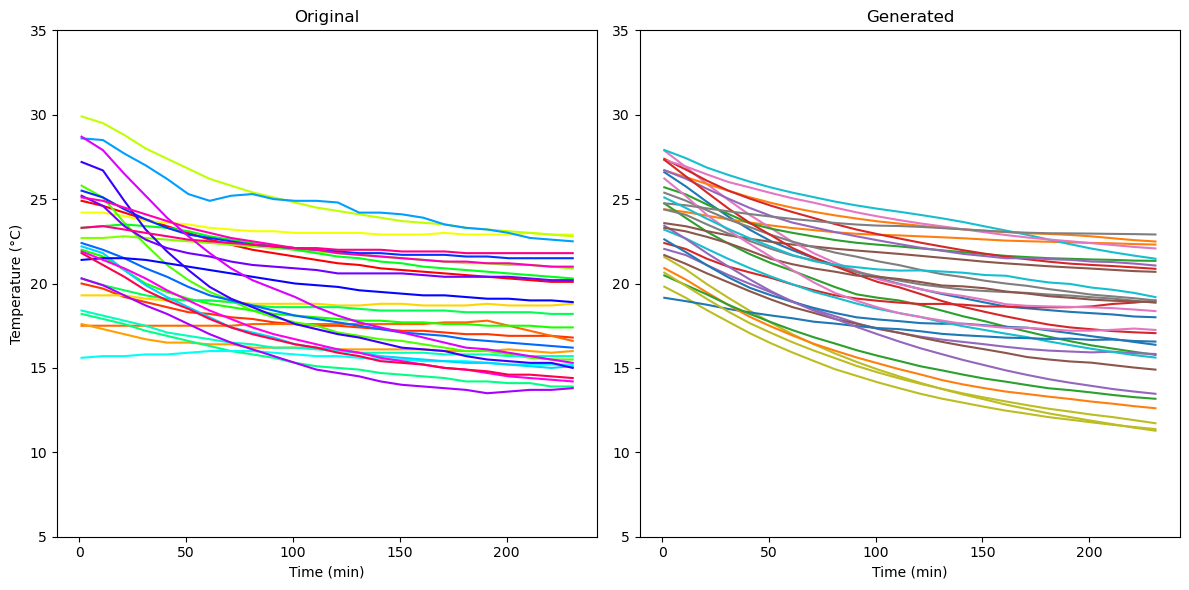

Training Progress:  83%|████████▎ | 458/550 [00:46<00:08, 10.26it/s]

Epoch 459: Train Loss = 0.2569, KL_phy = 0.8677, KL_delta = 4.9797, MSE = 0.1631, CE = 0.3290, Reg_Loss = 0.7826, Alpha = 0.0451
Validation Loss = 0.5152, Val_KL_phy = 0.8322, Val_KL_delta = 2.8553, Val_MSE = 0.3954, Val_CE = 0.1404, Val_Reg_Loss = 1.8368, Val_Alpha = 0.0451


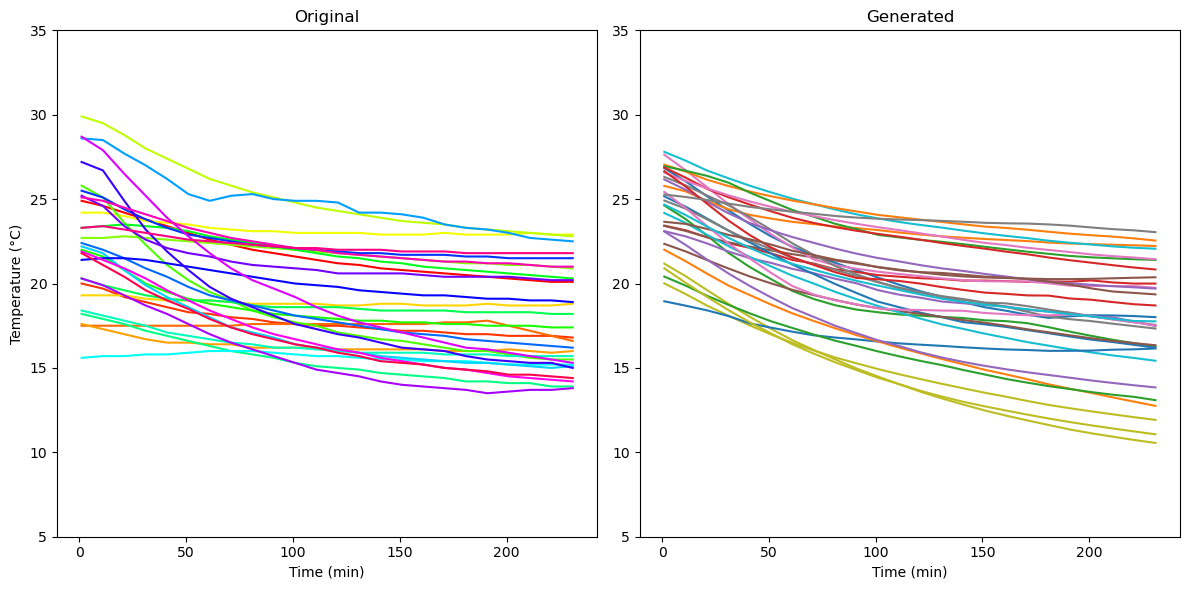

Training Progress:  88%|████████▊ | 485/550 [00:49<00:06, 10.21it/s]

Epoch 486: Train Loss = 0.2354, KL_phy = 0.8037, KL_delta = 4.9115, MSE = 0.1414, CE = 0.3248, Reg_Loss = 0.8509, Alpha = 0.0434
Validation Loss = 0.5204, Val_KL_phy = 0.7633, Val_KL_delta = 2.8323, Val_MSE = 0.3893, Val_CE = 0.1370, Val_Reg_Loss = 2.1948, Val_Alpha = 0.0433


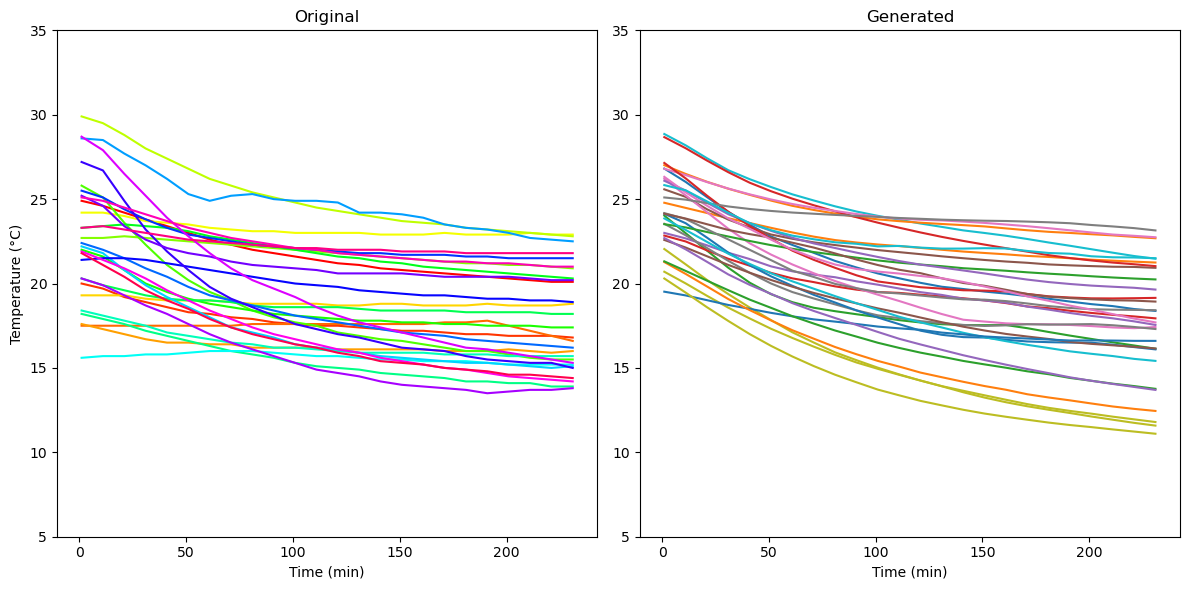

Training Progress:  93%|█████████▎| 512/550 [00:52<00:03, 10.22it/s]

Epoch 513: Train Loss = 0.2225, KL_phy = 0.8044, KL_delta = 4.8624, MSE = 0.1285, CE = 0.3221, Reg_Loss = 0.8948, Alpha = 0.0417
Validation Loss = 0.4998, Val_KL_phy = 0.7700, Val_KL_delta = 2.7526, Val_MSE = 0.3884, Val_CE = 0.1313, Val_Reg_Loss = 1.8269, Val_Alpha = 0.0417


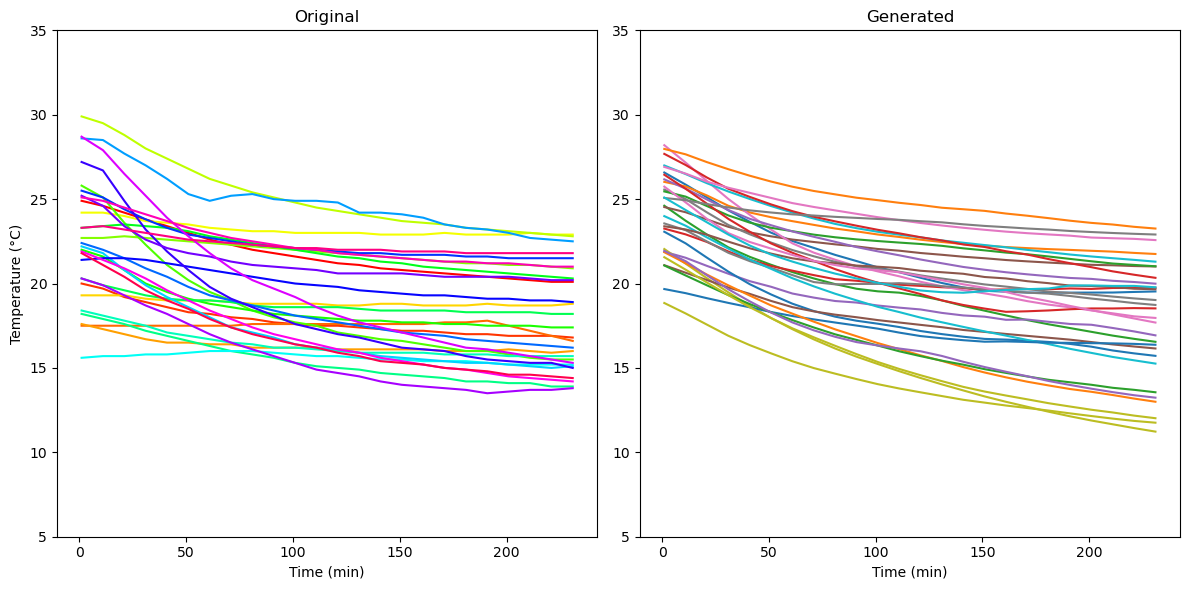

Training Progress:  98%|█████████▊| 539/550 [00:55<00:01, 10.22it/s]

Epoch 540: Train Loss = 0.2102, KL_phy = 0.7487, KL_delta = 4.8170, MSE = 0.1259, CE = 0.3231, Reg_Loss = 0.7142, Alpha = 0.0402
Validation Loss = 0.5365, Val_KL_phy = 0.6989, Val_KL_delta = 2.7124, Val_MSE = 0.4144, Val_CE = 0.1296, Val_Reg_Loss = 2.1921, Val_Alpha = 0.0401


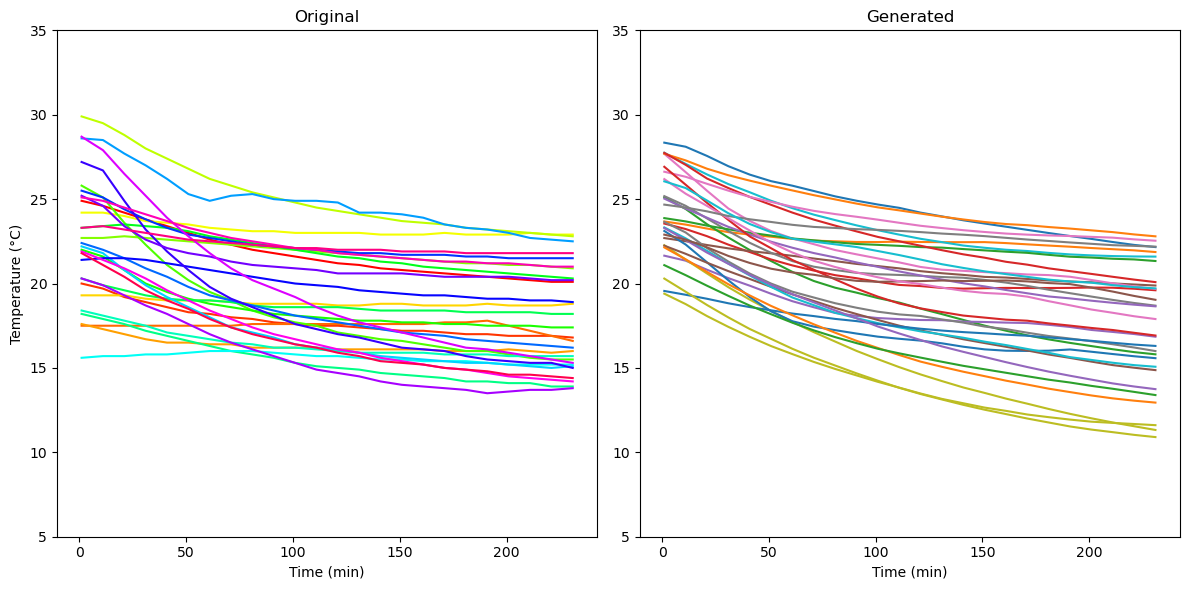

Training Progress: 100%|█████████▉| 548/550 [00:56<00:00,  9.34it/s]

Epoch 550: Train Loss = 0.1957, KL_phy = 0.6969, KL_delta = 4.7269, MSE = 0.1115, CE = 0.3193, Reg_Loss = 0.7564, Alpha = 0.0396
Validation Loss = 0.4805, Val_KL_phy = 0.6628, Val_KL_delta = 2.6661, Val_MSE = 0.3660, Val_CE = 0.1281, Val_Reg_Loss = 2.0517, Val_Alpha = 0.0396


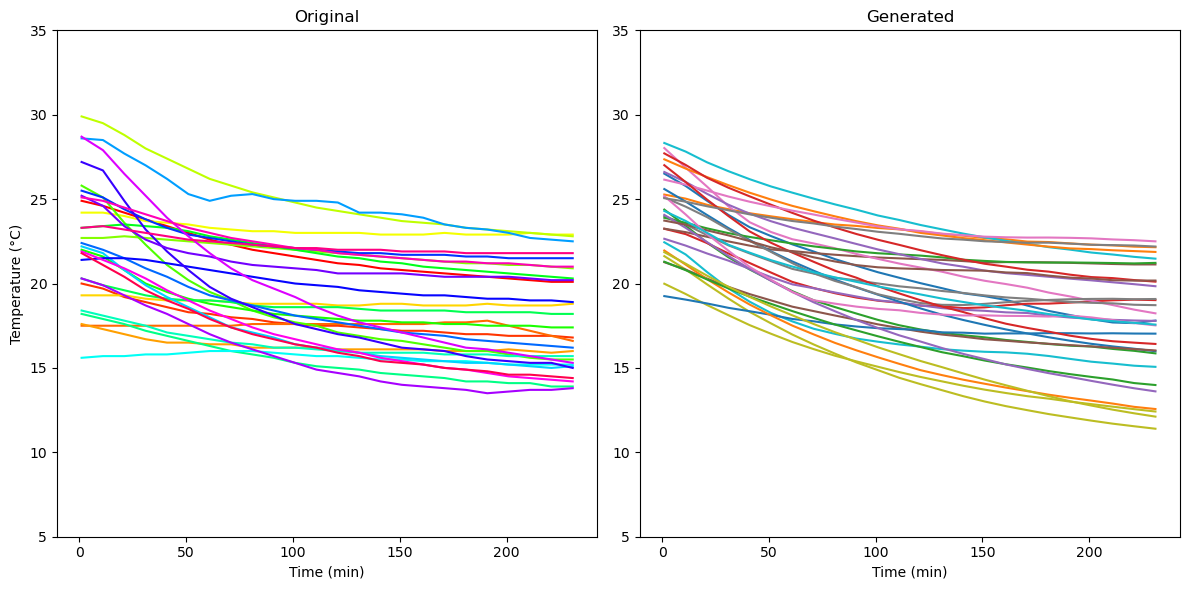

Training Progress: 100%|██████████| 550/550 [00:56<00:00,  9.69it/s]


In [8]:
num_epochs=550
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.01, 
                                       beta_max=0.01)
beta_annealed = annealing_strategy.get_beta_vector()
beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 30
min_T, max_T = 15, 30
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_c, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(5, 35))


In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_cooling.pth')